# Generate music with an RNN


## Setup

In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

2022-12-05 15:17:22.581923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 15:17:22.986453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 15:17:22.986510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-05 15:17:23.038083: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-05 15:17:24.321197: W tensorflow/stream_executor/platform/de

In [10]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [2]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 7s 0us/step


In [3]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

In [4]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_15_R1_2015_wav--4.midi


In [5]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [11]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [12]:
display_audio(pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [13]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [14]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=63, note_name=D#4, duration=0.0479
1: pitch=63, note_name=D#4, duration=0.0240
2: pitch=63, note_name=D#4, duration=0.0333
3: pitch=63, note_name=D#4, duration=0.0271
4: pitch=65, note_name=F4, duration=0.1500
5: pitch=63, note_name=D#4, duration=0.1344
6: pitch=61, note_name=C#4, duration=0.1135
7: pitch=58, note_name=A#3, duration=0.0437
8: pitch=51, note_name=D#3, duration=0.0385
9: pitch=39, note_name=D#2, duration=0.0385


In [16]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,63,0.698958,0.746875,0.000000,0.047917
1,63,1.029167,1.053125,0.330208,0.023958
2,63,1.129167,1.162500,0.100000,0.033333
3,63,1.243750,1.270833,0.114583,0.027083
4,65,1.541667,1.691667,0.297917,0.150000


In [18]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#4', 'D#4', 'D#4', 'F4', 'D#4', 'C#4', 'A#3', 'D#3',
       'D#2'], dtype='<U3')

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

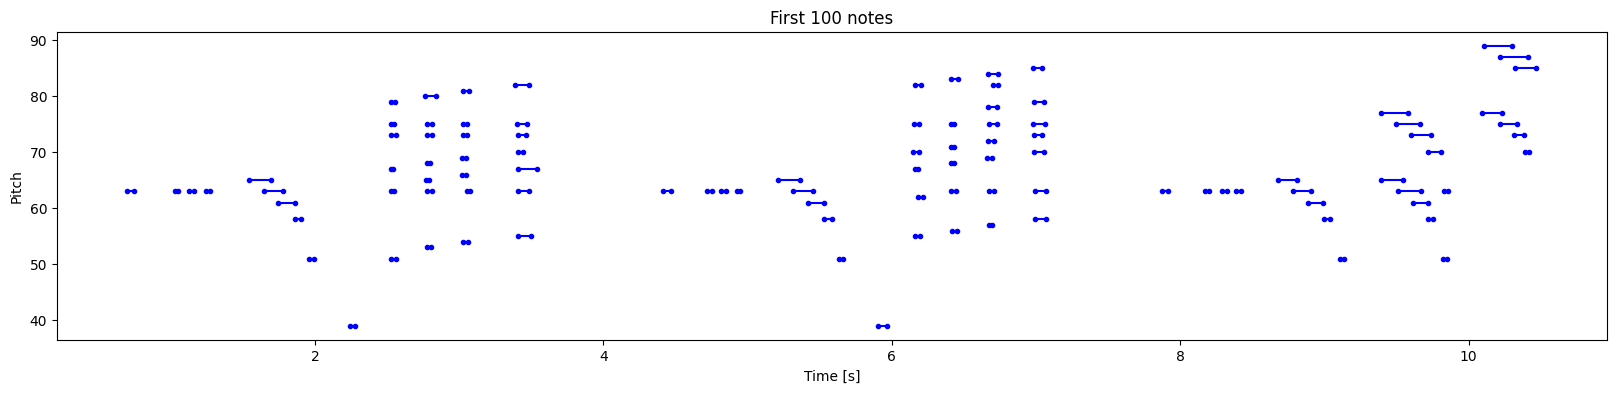

In [20]:
plot_piano_roll(raw_notes, count=100)

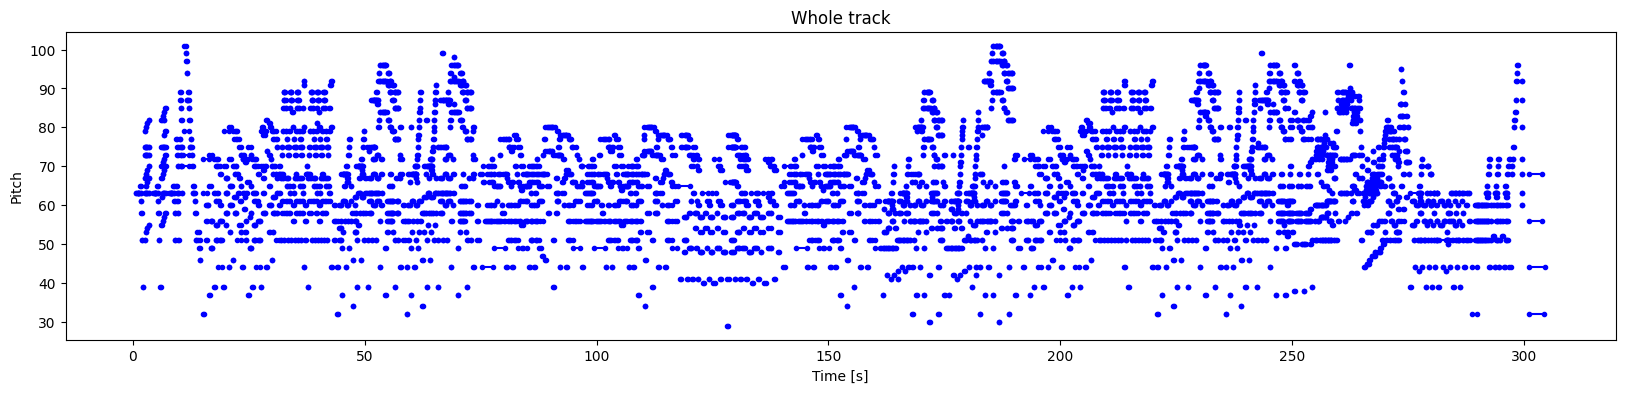

In [21]:
plot_piano_roll(raw_notes)

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

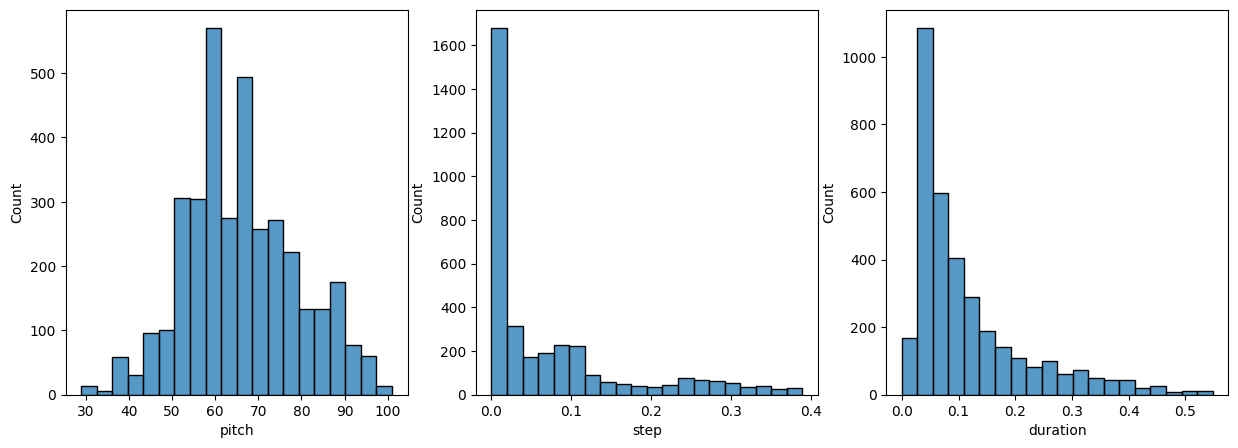

In [23]:
plot_distributions(raw_notes)

## Create a MIDI file

In [24]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [25]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [26]:
display_audio(example_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


## Create the training dataset

In [29]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [31]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 15125


In [34]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [35]:
train_notes

array([[6.70000000e+01, 0.00000000e+00, 6.97916667e-02],
       [5.50000000e+01, 2.18750000e-02, 3.64583333e-02],
       [7.10000000e+01, 7.50000000e-02, 9.79166667e-02],
       ...,
       [5.30000000e+01, 1.45833333e-02, 5.01875000e+00],
       [3.70000000e+01, 3.33333333e-02, 5.45520833e+00],
       [4.40000000e+01, 7.29166667e-03, 4.61250000e+00]])

In [36]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2022-12-05 16:00:55.348742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-05 16:00:55.350399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 16:00:55.350623: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-05 16:00:55.350933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-05 16:00:55.351240: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [38]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [39]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [40]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5234375  0.         0.06979167]
 [0.4296875  0.021875   0.03645833]
 [0.5546875  0.075      0.09791667]
 [0.578125   0.10208333 0.09270833]
 [0.3359375  0.103125   0.03229167]
 [0.6171875  0.         0.096875  ]
 [0.578125   0.08958333 0.084375  ]
 [0.5546875  0.109375   0.08645833]
 [0.578125   0.09166667 0.06666667]
 [0.5546875  0.09583333 0.06458333]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=64.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.09062499999999973>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.07187500000000036>}


In [41]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [42]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

In [43]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [44]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [45]:
losses = model.evaluate(train_ds, return_dict=True)
losses

235/235 [==============================] - 9s 18ms/step - loss: 5.1862 - duration_loss: 0.2638 - pitch_loss: 4.8560 - step_loss: 0.0664


{'loss': 5.186228275299072,
 'duration_loss': 0.26379185914993286,
 'pitch_loss': 4.856017112731934,
 'step_loss': 0.06642034649848938}

In [46]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [47]:
model.evaluate(train_ds, return_dict=True)

235/235 [==============================] - 5s 16ms/step - loss: 0.5730 - duration_loss: 0.2638 - pitch_loss: 4.8560 - step_loss: 0.0664


{'loss': 0.573013424873352,
 'duration_loss': 0.26379185914993286,
 'pitch_loss': 4.856017112731934,
 'step_loss': 0.06642034649848938}

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [49]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
235/235 [==============================] - 10s 37ms/step - loss: 0.3375 - duration_loss: 0.0923 - pitch_loss: 4.1448 - step_loss: 0.0380
Epoch 2/50
235/235 [==============================] - 9s 37ms/step - loss: 0.3168 - duration_loss: 0.0830 - pitch_loss: 3.9442 - step_loss: 0.0365
Epoch 3/50
235/235 [==============================] - 9s 39ms/step - loss: 0.3125 - duration_loss: 0.0814 - pitch_loss: 3.9189 - step_loss: 0.0351
Epoch 4/50
235/235 [==============================] - 10s 42ms/step - loss: 0.3101 - duration_loss: 0.0798 - pitch_loss: 3.9086 - step_loss: 0.0348
Epoch 5/50
235/235 [==============================] - 11s 46ms/step - loss: 0.3080 - duration_loss: 0.0787 - pitch_loss: 3.8956 - step_loss: 0.0345
Epoch 6/50
235/235 [==============================] - 9s 38ms/step - loss: 0.3068 - duration_loss: 0.0777 - pitch_loss: 3.8856 - step_loss: 0.0349
Epoch 7/50
235/235 [==============================] - 8s 36ms/step - loss: 0.3046 - duration_loss: 0.0769 - pitch_l

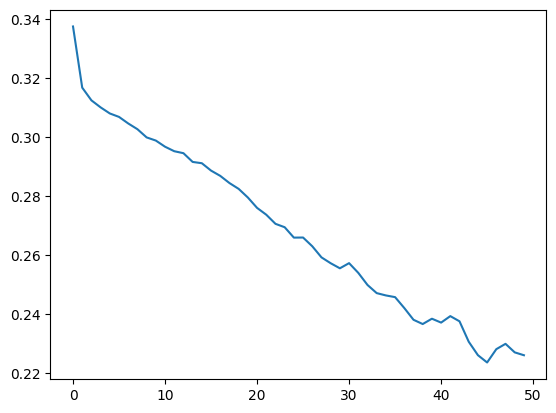

In [50]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [51]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [52]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 26ms/step


In [53]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,68,0.027246,0.075178,0.027246,0.102424
1,96,0.302492,0.410811,0.329738,0.740550
2,94,0.358360,0.505542,0.688098,1.193640
3,82,0.365297,0.525974,1.053395,1.579369
4,89,0.367210,0.535182,1.420604,1.955786
5,87,0.367339,0.529209,1.787943,2.317152
6,78,0.369231,0.530403,2.157175,2.687577
7,89,0.370611,0.537797,2.527786,3.065583
8,59,0.369886,0.529281,2.897672,3.426953
9,89,0.372624,0.580138,3.270295,3.850433


In [54]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [ ]:
# CODE TO DOWNLOAD THE GENERATED MUSIC 
#from google.colab import files
#files.download(out_file)

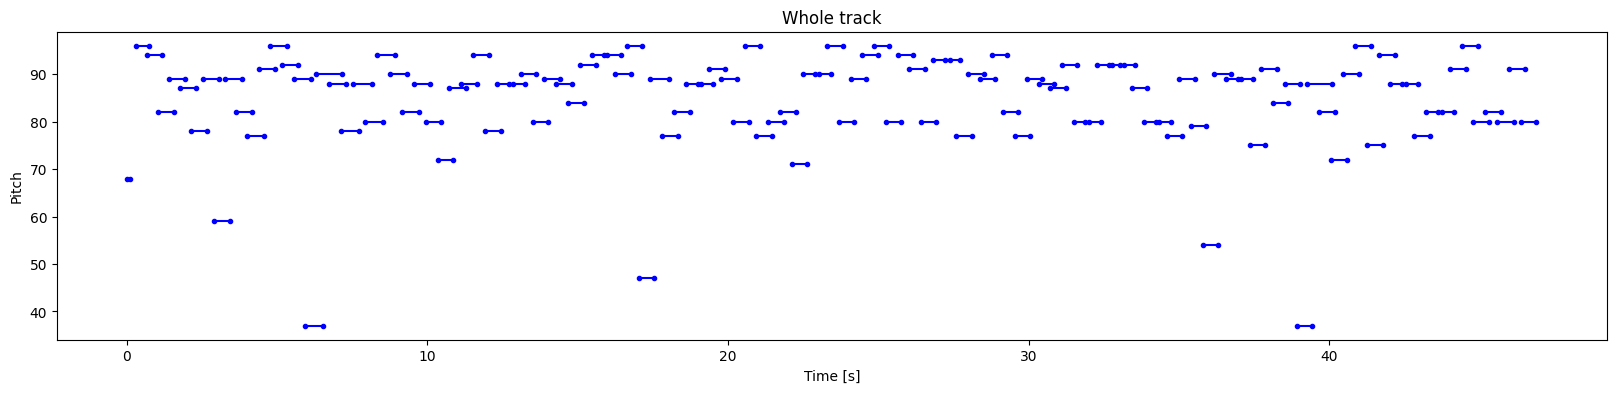

In [55]:
plot_piano_roll(generated_notes)

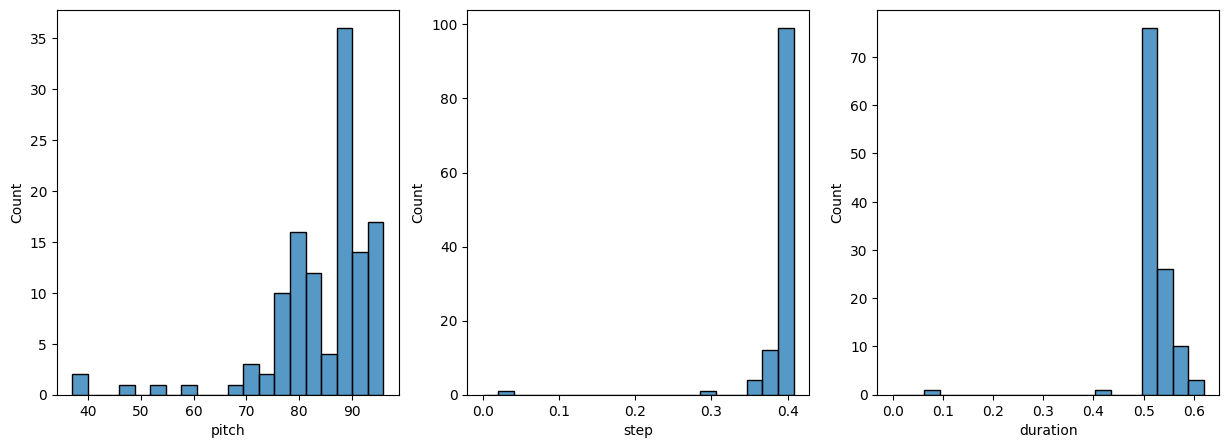

In [56]:
plot_distributions(generated_notes)